Article:
https://cseweb.ucsd.edu/~jmcauley/pdfs/www19.pdf

https://www.sciencetimes.com/articles/20642/20190423/new-personalized-deep-learning-tool-recommends-routes-by-estimating-runners-heart-rates.html

Data and instruction:
https://sites.google.com/eng.ucsd.edu/fitrec-project/home


The specific version of the data was cleaned: 
## Insights from the dataset and paper
 * Lots of workout sessions, and reasonable number of users
 * The average span for individual user is 733 days. Seems promising for a longitudinal study on how exercises change heart physiology.
 * During workout, individual's heart rate varies a lot. Factors include gender, workout type, speed, workout duration, and altitude elevation. Other implicit factors could be exercise frequency, how many days since starting of exercise, which can be extracted from the data. 
 * Unfortunately, age and body weight are important features missing in the dataset. However, on the feature engineering side, we can normalized first the data within individual user, and then examine the improvement of heart rate within individual user, compare those across different users, and how different factors influence the change of heart rate at the population level.
 * Build a model to predict long-term change of heart rate based on exercise statistics, and give personalized recommendation accordingly.
 * Tree model is probably the way to go, noted that the interaction between features are not trivial/linear. For example, figure 4: altitude influences the heart rate during biking differently from that during running
 
 <img src="stats.png" style="width:500px;height:600px;">

# Notes on the data:
### 'HR.csv': the Dataframe of workout with heart_rate recorded
    shape = (253020, 13)
* 'userId': unique user ID, there are total 1104 users. 
* 'gender': 'male' or 'female'
* 'id': unique id for each workout session
* 'sport': workout type
* 'ave_heart_rate': heart rate in beats per minute (bpm), averaged across the session
* 'speed': a time series of speed, during workout, 500 samples.
* 'ave_speed': averaged speed (Km/hour)
* 'ave_altitude': averaged altitude (meter)
* 'max_altitude': maximum altitude index, and maximum altitude (will be used to infer uphill or downhill)
* 'min_altitude': minimum altitdue index, and minimum altitude
* 'start_end': Start and end timestamps, in second
* 'ave_longitude', 'ave_latitude': averaged longitude and latitude

### 'Meta.csv': the metadata for all workout sessions
    shape = (962190, 12)
* 'userId': unique user ID, there are total 1364 users.
* 'hydration': ?
* 'gender': 'male' or 'female'
* 'id': unique id for each workout session
* 'sport': workout type
* 'ascent', 'descent': total ascent and descent in meters
* 'calories': total calories consumed
* 'distance': total distance in Km
* 'duration': session duration in second
* 'weather': there are 37 unique weather conditions, unknown
* 'start_time': workout starting time. 

## Example extracted features


| |UserID | Gender | Sport | Duration | Speed_mean | Speed_dev | Distance | Altitude_mean| Altitude_elevation_abs| Altitude_Dev | Longitude | Latitude| Heart_rate| Sessions_since_beginning |
|---:|:-------------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
| Session1 | 100 | male | bike | 3300 | | | | | | | | |||
| Session2 | 200 | female | running | 2700 | | | | | | ||| | |
| ... | ... | ... | ... | ... | | | | | | ||| | |

# [6/28/2022](#628)

### Data:  Meta.csv and HR.csv in the [Google folder](https://drive.google.com/drive/folders/19LxXlxvg2ozc_b3wlVFhXxrClnFLvnoh)

### Exploratory Analysis in [notebook](https://github.com/wangjing0/RS/blob/main/Analysis.ipynb)

### Findings
* some sports have large gender difference in heart rate
* 'duration', 'distance', and 'calories' are close to normally distributed after log tranformation, so transform them.
* sports are clustered in the feature space of ('duration','distance','carlories') -> can be used for recommending sport according to individual selection. 
* Within individual user, heart rate are highly correlated with the calories_rate (calories per unit time). -> can be used for calorie prediction. 

In [467]:
#stri = (df_hr_proper['speed(m/s)'][0])
df_hr_speed_proper = df_hr_proper[['id','heart_rate','speed(m/s)']]
df_hr_speed_proper.head()

,id,heart_rate,speed(m/s)
0,396826535,[100. 111. 120. 119. 120. 116. 125. 128. 131. ...,[ 0. 2.99611712 4.68300039 4.426539...
1,392337038,[100. 105. 111. 110. 108. 115. 126. 130. 132. ...,[ 0. 3.43885299 3.97920185 4.821890...
2,389643739,[ 99. 105. 113. 110. 109. 110. 108. 121. 116. ...,[ 0. 2.11422888 4.53498053 5.049129...
3,386729739,[ 99. 105. 113. 109. 112. 116. 116. 114. 114. ...,[ 0. 3.51697022 4.68025841 5.612893...
4,383186560,[110. 113. 114. 116. 123. 126. 129. 135. 137. ...,[ 0. 3.60678252 4.79945428 5.570207...


In [418]:
import os
df_hr_proper.iloc[0]['heart_rate'].replace('\n', '')

'[100. 111. 120. 119. 120. 116. 125. 128. 131. 132. 135. 137. 142. 143. 143. 148. 148. 148. 142. 141. 143. 146. 151. 149. 146. 147. 157. 155. 159. 152. 146. 147. 154. 157. 153. 143. 142. 138. 135. 134. 133. 133. 134. 135. 143. 142. 146. 151. 155. 163. 161. 150. 140. 139. 142. 147. 158. 158. 159. 166. 167. 166. 164. 163. 157. 147. 143. 142. 143. 143. 142. 139. 141. 152. 160. 148. 150. 154. 148. 144. 149. 154. 162. 162. 163. 164. 153. 150. 145. 150. 159. 159. 161. 165. 167. 169. 167. 161. 155. 151. 152. 152. 150. 148. 147. 146. 143. 145. 151. 155. 155. 161. 164. 164. 161. 156. 149. 141. 140. 139. 150. 151. 153. 153. 150. 143. 142. 153. 153. 152. 153. 153. 154. 146. 141. 138. 146. 147. 146. 144. 148. 151. 154. 157. 153. 151. 155. 155. 150. 146. 150. 155. 160. 161. 164. 160. 154. 148. 156. 160. 163. 157. 154. 159. 160. 163. 162. 156. 151. 152. 156. 157. 150. 144. 151. 159. 163. 162. 155. 155. 152. 151. 150. 150. 146. 141. 142. 148. 153. 157. 161. 169. 168. 162. 157. 160. 167. 172. 173. 168

In [502]:
#df_hr_speed_proper.to_csv('./data/HR_speed_proper.csv')
df_hr_speed_proper_hr = df_hr_proper['heart_rate'].apply(lambda x:[float(s) for s in eval(re.sub('\s+', ',', x.replace('\n','').replace('[ ','[').replace('[ ','['))) ] )

In [446]:
import re
arr = df_hr_proper.iloc[0]['speed(m/s)']
#len(eval(re.sub('\s+', ',', arr.replace('\n','').replace('[ ','['))))
#arr.replace('\n','').replace('[ 0.\ ','[')

500

In [491]:
speed_ = df_hr_proper.iloc[7:10]['speed(m/s)'].apply(lambda x:[float(s) for s in eval(re.sub('\s+', ',', x.replace('\n','').replace('[ ','['))) ] )
#speed_.iloc[0]

In [510]:
df_hr_speed_proper_speed = df_hr_proper['speed(m/s)'].apply(lambda x:[float(s) for s in eval(re.sub('\s+', ',', x.replace('\n','').replace('[ ','[').replace('[ ','['))) ] if len(x)>10 else [None] )

NameError: name 'inf' is not defined

In [512]:
df_hr_speed_proper_hr.shape

(167783,)

In [503]:
np.save('./data/df_hr_speed_proper_hr.npy', df_hr_speed_proper_hr,allow_pickle=True)

In [511]:
#test2 = np.load('./data/df_hr_speed_proper_hr.npy', allow_pickle=True)
df_hr_speed_proper.shape

(167783, 3)

In [518]:
df_hr_speed_proper_hr_mean = df_hr_speed_proper_hr.map(lambda x:np.mean(x))

In [523]:
df_hr_speed_proper_hr_std = df_hr_speed_proper_hr.map(lambda x:np.std(x))

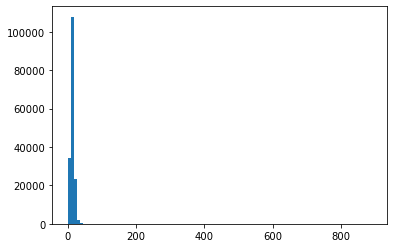

In [524]:
plt.hist(df_hr_speed_proper_hr_std, bins = 100);

In [525]:
df_hr_mean_std = pd.DataFrame({'id':df_hr_speed_proper['id'],
                               'hr_mean':df_hr_speed_proper_hr_mean,
                               'hr_std':df_hr_speed_proper_hr_std,})
df_hr_mean_std

,id,hr_mean,hr_std
0,396826535,152.650,10.229736
1,392337038,147.710,10.970046
2,389643739,140.554,11.319500
3,386729739,147.020,11.414885
4,383186560,167.154,10.414523
...,...,...,...
167778,30369221,169.894,12.732587
167779,596955589,108.846,22.735221
167780,24888434,160.842,9.856421
167781,538385734,113.518,14.371001


In [531]:
#df_hr_mean_std.to_csv('./data/df_hr_mean_std.csv', index=False)
test = pd.read_csv('./data/df_hr_mean_std.csv')

In [532]:
test

,id,hr_mean,hr_std
0,396826535,152.650,10.229736
1,392337038,147.710,10.970046
2,389643739,140.554,11.319500
3,386729739,147.020,11.414885
4,383186560,167.154,10.414523
...,...,...,...
167778,30369221,169.894,12.732587
167779,596955589,108.846,22.735221
167780,24888434,160.842,9.856421
167781,538385734,113.518,14.371001


In [389]:
def str2num(x):
    values = np.array([])
    if type(x) == str:
        x = x.split()
        print(len(x))
        for item in x:
            if item =='[':
                pass
            else:
                item = item.strip('[]')
                values = np.append(values, float(item.strip()))
    return values

df_speed =  df_hr_proper.iloc[0:2]['speed(m/s)'].apply(str2num)
df_speed

501
501


0    [0.0, 2.99611712, 4.68300039, 4.42653993, 6.81...
1    [0.0, 3.43885299, 3.97920185, 4.82189054, 4.09...
Name: speed(m/s), dtype: object

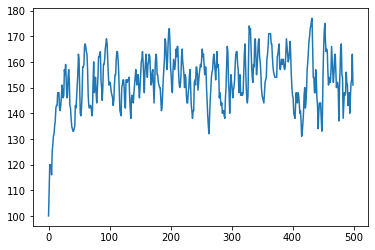

In [381]:

df_heart_rate = df_hr_proper.iloc[0:2]['heart_rate'].apply(str2num)
plt.plot(df_heart_rate[0]);

In [369]:
df_hr_proper['heart_rate'].notnull().sum()

167783

In [343]:
df_derivative = pd.read_csv('./data/HR_derivative_features.csv')
print(df_derivative.shape)
df_derivative.head()

(253020, 20)


,gender,id,userId,sport,max_altitude,mean_altitude,min_altitude,max_heart_rate,mean_heart_rate,min_heart_rate,max_longitude,mean_longitude,min_longitude,max_latitude,mean_latitude,min_latitude,total_time,max-min_heart_rate,max-min_altitude,max-min_longitude
0,male,396826535,10921915,bike,74.2,43.0712,14.6,177,152.650,100,24.651084,24.480066,24.337810,60.234857,60.182107,60.133427,7589,77,59.6,0.313274
1,male,392337038,10921915,bike,67.8,35.7248,17.2,174,147.710,100,24.651122,24.546053,24.457660,60.204310,60.179142,60.156585,4440,74,50.6,0.193463
2,male,389643739,10921915,bike,94.0,62.4256,33.4,168,140.554,99,24.651070,24.505033,24.391716,60.225367,60.174214,60.133453,6749,69,60.6,0.259354
3,male,386729739,10921915,bike,64.0,32.6104,12.4,178,147.020,99,24.651117,24.544119,24.457654,60.204322,60.179844,60.156567,4519,79,51.6,0.193463
4,male,383186560,10921915,bike (transport),37.8,22.7620,9.8,183,167.154,110,24.817608,24.731128,24.649798,60.184767,60.178065,60.171599,1357,73,28.0,0.167810


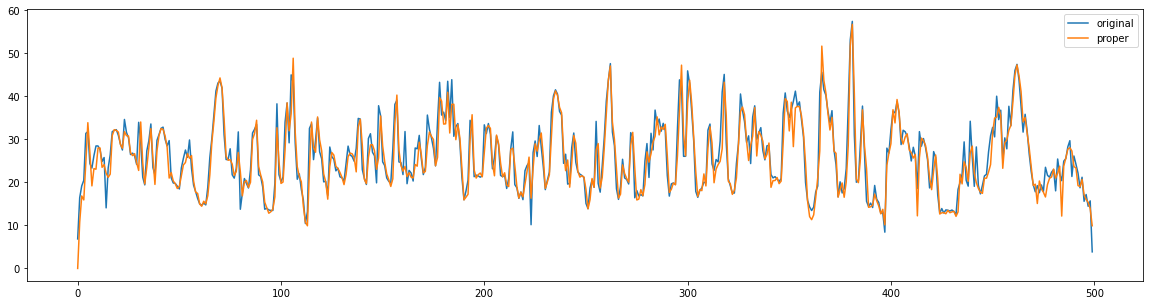

In [366]:
plt.figure(figsize=(20,5))
plt.plot(eval(df_hr['speed'][0]), label='original');
plt.plot(test[0]*3.6,label='proper')
plt.legend();

### 1. A simple RecSys without user data
* Data. Item features will be extracted from text (NLP required). 

| | Feature1(numeric) | Feature2(categorical)... | Descriptions (text) | Customer Reviews Ratings (numeric)| Customer Reviews (text)|
|---:|:-------------|:-----------|:-----------|:-----------|:-----------|
| Item1 | 100 | 'red'   | 'xxxxx'  | 1.0 | 'xxxxx'  | 
| Item2 | 200| 'blue'  | 'xxxxx'  | 4.0 | 'xxxxx'  | 
| Item3 | 200  | 'green'  | 'xxxxx'  | 4.5| 'xxxxx'  | 

* How does it work?
    * vectorize each item -> feature engineering with NLP tools
    * cluster items according to their features -> unsupervised learning methods such as Kmeans, DBSCAN, LDA or get a hierarchical structure
    * We can manually label few examples, and use semi-supervised learning methods for accurate clustering.
    * can also do keyword search. (a search engine)
         * vectorize the search keywords in a similar way as item descriptions
         * match the keyword vector with cluster averaged vector -> return the class tag of the clustering.-> a fuzzy search, from coarse to fine search use the hierarachical structures within the items.
         * match keyword vector with item vectors using similarity -> return individual item -> an itemwise search.
         * get the top K items according to similarity -> a ranking problem

### 2. A RecSys with content based filtering
* Data
    * Item information similar to in 1.
    * For user-item interaction, below is an example.
    * All we need is who interacted with what, we do not need detailed profile of customers.

| interaction index | User ID | Item ID | Interaction type/ratings (numeric, categorical) (optional)| Timestamp (optional) |
|---:|:-------------|:-----------|:-----------|:-----------|
| 0 | u1 |  v100 | 'view'  / 1.0 |  2022-6-20 13:56:00  | 
| 1 | u2 | v33  | 'purchase'  / 4.0 | 2022-6-20 13:56:01  | 
| 2 | u3  | v679  | 'comment'  / 4.5| 2022-6-20 13:56:59   | 

* Data processing: Convert the above user-interaction-item triplet into an interaction matrix $ X $
    * If the interaction type/ratings are specified, NaN means no interaction history, and graded value indicates strength of interaction, we will have a regression case.
    * If the interaction type/ratings are not specified, we will replace NaN with 0. use it as a binary classification case: 1 means interacted, 0 means not interacted.
    
| | item1 | item2 | item3 | item4 |
|---:|:-------------|:-----------|:-----------|:-----------|
| user0 | NaN |  1.0 | 3.0 | 0|
| user1 | 2.0 | 1.0  | 0 | 4.5|
| user2 | 0  | 2.5 | 5.0 | NaN |

* Content based filtering: How does it work?      
    * same as in section 1, we first vectorize each item
    * Let's say user A bought item x, recommend a similar item y such that a similarity score function sim(x,y) is highest. -> A recommendation/ranking problem
    * If the predicted A vs y relation is a rating score. Can we predict y accurately? -> A regression problem
    * If the predicted A vs y relation is binary -> classification problem
   

### 3. A RecSys with collaborative filtering 

* Collaborative filtering: how does it work?
    * Both user A and B purchased x, given user A also bought y, we should recommend y to B.
    * Concept is simple, implementation uses Matrix Factorization. The input is the interaction matrix X, the output is the two lower rank matrix U and V called factors

    * $X = U^T V$
         
         X has shape of (m,n) <br> 
         U has shape of (k,m)-> so called user embedding <br> 
         V has shape of (k,n)-> so called item embedding <br> 
         m is the number of users, n is the total number of items, k is the preset number of factors - "stereotypes" of user/item groups - usually k << m,n.
    * Loss function = MSE + L2 regularization
        $$ L(U,V) = \sum_{i,j}(u^T_i v_j - X_{i,j})^2+ \lambda (|u_i|^2 + |v_j|^2)$$
    * The graded rating can be used for regression. The binary value can be used for classification
    
    

### 4. User-attribute-aware collaborative filtering

* with item, user-item information
* Additional User attributes can refine the collaborative filtering further, but we will not go into the rabbit hole


| | Gender| Age | Geographic info (zipcode, IP etc)|
|---:|:-------------|:-----------|:-----------|
| User1 | F | 20   | 'xxxxx' |
| User2 | M | 40  | 'xxxxx'  | 
| User3 | M | 50  | 'xxxxx'  | 



## Problem statement
* Bussiness problems
* Metrics


## Data
* Items / Users / User-Item

## Model
* Feature selection
* Feature engineering
* how to train-val-test split
* 

## Deployment
* 